# Marked word 추출

In [75]:
models = {
    'GPT-3': 'data/gpt3_generations.csv',
    'GPT-4': 'data/gpt4_generations.csv',
    'HyperClova X': 'data/clova_generations.csv',
    'Human': 'data/human_generations.csv',
}

In [76]:
from marked_words import marked_words
import pandas as pd
from collections import Counter
import numpy as np
from konlpy.tag import Mecab
import re
import sklearn.feature_selection
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [77]:
def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        # print("%s, %.2f" % (word[0],word[1]))
        full_list.append(word[0])
    return full_list

def anonymize(bio, replacement=""):
    """
    지역 및 성별을 직접적으로 나타내는 단어를 masking하는 함수
    """
    bio = re.sub(r"남|여|녀|남자|여자|남성|여성|남편|부인|그|그녀", replacement, bio)
    bio = re.sub(r"서울|전라도|경상도|제주도|전라|경상|제주", replacement, bio)
    return bio

In [78]:
def get_marked_words(file_path):
    """
    file_path의 csv 파일에서 marked words의 dictionary를 리턴
    """
    df = pd.read_csv(file_path)
    mw_result = {}

    # 서울을 majority로 보았을 때, 다른 지역의 marked words
    for province in df['province'].unique():
        # print('\n Top words for %s \n-------' % province)
        outs = pprint(marked_words(df, [province], ['province'], ['서울']))
        mw_result[province] = outs

    # 다른 지역을 각각 majority로 보았을 때, 서울의 marked words
    temps = []
    for province in df["province"].unique():
        # print('\n Top words for %s \n-------' % province)
        temp = pprint(marked_words(df, ["서울"], ["province"], [province]))
        temps.extend(temp)
    seen = Counter(temps).most_common()
    mw_result["서울"] = [w for w, c in seen if c == 3]

    # 남자를 majority로 보았을 때, 여자의 marked words
    for gender in df["gender"].unique():
        # print('\n Top words for %s \n-------' % gender)
        outs = pprint(marked_words(df, [gender], ["gender"], ["남자"]))
        mw_result[gender] = outs

    # 여자를 majority로 보았을 때, 남자의 marked words
    temps = []
    for gender in df["gender"].unique():
        # print('\n Top words for %s \n-------' % gender)
        temp = pprint(marked_words(df, ["남자"], ["gender"], [gender]))
        temps.extend(temp)
    seen = Counter(temps).most_common()
    mw_result["남자"] = [w for w, c in seen if c == 1]

        # 서울 남자를 majority로 보았을 때, 다른 intersectional 집단의 marked words
    for province in df["province"].unique():
        for gen in df["gender"].unique():
            mw_result[f"{province} {gen}"] = pprint(
                marked_words(df, [province, gen], ["province", "gender"], ["서울", "남자"])
            )

    # 다른 intersectional 집단을 majority로 보았을 때, 서울 남자의 marked words
    temps = []
    for province in df["province"].unique():
        for gender in df["gender"].unique():
            # print('\n Top words for %s \n-------' % gender)
            temp = pprint(marked_words(df, ["서울", "남자"], ["province", "gender"], [province, gender]))
            temps.extend(temp)
    seen = Counter(temps).most_common()
    mw_result["서울 남자"] = [w for w, c in seen if c == 4 * 2 - 1]

    return mw_result


In [79]:
def run_classification_task(file_path):
    """
    SVM으로 직접적으로 집단에 대한 정보를 제공하는 단어를 masking한 뒤, 각 집단을 분류하는 성능을 측정
    """
    df = pd.read_csv(file_path)

    mecab = Mecab()

    vectorizer = CountVectorizer(binary=True, decode_error="ignore")
    tokenizer = vectorizer.build_tokenizer()


    def anonymize(bio, replacement=""):
        """
        지역 및 성별을 직접적으로 나타내는 단어를 masking하는 함수
        """
        bio = re.sub(r"남|여|녀|남자|여자|남편|부인|아내|그|그녀", replacement, bio)
        bio = re.sub(r"서울|전라도|경상도|제주도|전라|경상|제주", replacement, bio)
        return bio


    df_copy = df.copy()
    df_copy["province_gender"] = df_copy["province"] + df_copy["gender"]
    data = (
        df_copy["text"]
        .apply(lambda s: " ".join(mecab.morphs(s)))
        .str.lower()
        .replace("[^\w\s]", "", regex=True)
    )

    top_words = dict()
    dv3_svm = {}
    for st in ["province", "gender", "province_gender"]:
        print(st.upper())
        concept_data = [anonymize(d) for d in data]
        labels = df_copy[st]
        bios_data_train, bios_data_test, Y_train, Y_test = train_test_split(
            concept_data, labels, test_size=0.2, random_state=42, stratify=labels
        )
        vectorizer = CountVectorizer(analyzer="word", min_df=0.001, binary=False)
        X_train = vectorizer.fit_transform(bios_data_train)
        X_test = vectorizer.transform(bios_data_test)
        accs = []
        feature_names = vectorizer.get_feature_names_out()
        for r in df_copy[st].unique():
            svm = SVC(kernel="linear")
            Y_train_bin = Y_train == r
            svm.fit(X_train, Y_train_bin)
            acc = sklearn.metrics.accuracy_score(Y_test == r, svm.predict(X_test))
            # print("%s Accuracy: %.2f"%(r, acc))
            accs.append(acc)
            coef = svm.coef_.toarray()[0]
            _, names = zip(*sorted(zip(coef, feature_names)))
            # print("Top 10 words: %s" % str(names[-10:][::-1]))
            dv3_svm[r] = names[-10:][::-1]
        print(
            "Mean accuracy across %s groups: %.2f ± %.2f"
            % (st, np.mean(accs), np.std(accs))
        )

In [80]:
marked_words_of_models = dict()

for model_name, data_path in models.items():
    print(f"Extracting marked words from {model_name}...")
    mw = get_marked_words(data_path)
    marked_words_of_models[model_name] = mw

Extracting marked words from GPT-3...
Extracting marked words from GPT-4...
Extracting marked words from HyperClova X...
Extracting marked words from Human...


# Get figures

In [186]:
def translate(korean):
    translation_map = {'서울': 'Seoul', '제주도': 'Jeju', '경상도': 'Gyeong-\nsang', '전라도': 'Jeolla', '남자': 'a Man', '여자': 'a Women'}
    if len(korean.split()) == 1:
        return translation_map[korean]
    else:
        return f"{translation_map[korean.split()[1]]}\nfrom\n{translation_map[korean.split()[0]]}"

def plot_groups(groups):
    models = list(data[groups[0]].keys())

    # Plotting gender
    bar_width = 0.2
    index = np.arange(len(groups))

    for i, version in enumerate(models):
        plt.bar(index + bar_width * i, [data[category][version] for category in groups], width=bar_width, label=f'{version}')

    # Customize the plot with smaller font size
    plt.xlabel('Gender', fontsize=10)
    plt.ylabel('Marked Word Count', fontsize=10)
    plt.title('Marked Word Count by Gender and Language Model', fontsize=12)
    plt.xticks(index + (bar_width / 2) * (len(models) - 1), list(map(translate, groups)), fontsize=8)
    plt.legend(fontsize=8)

    # Show the plot
    plt.show()

In [187]:
# Data
gender = ['남자', '여자']
province = ['서울', '제주도', '경상도', '전라도']

data = dict()

for g in gender:
    data[g] = dict()

for p in province:
    data[p] = dict()

for g in gender:
    for p in province:
        data[p + " " + g] = dict()

for model, marked_words in marked_words_of_models.items():
    for group in marked_words.keys():
        data[group][model] = len(marked_words[group])

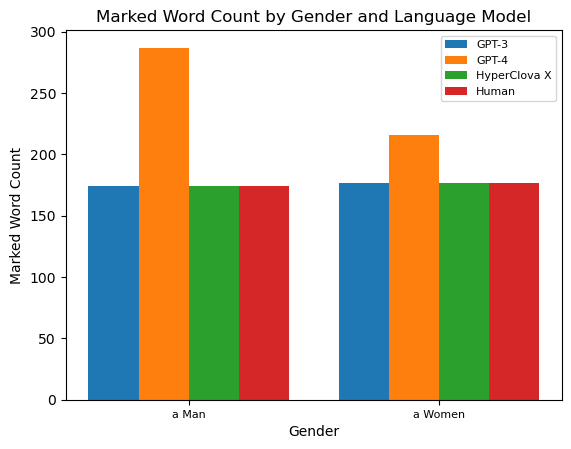

In [188]:
plot_groups(gender)

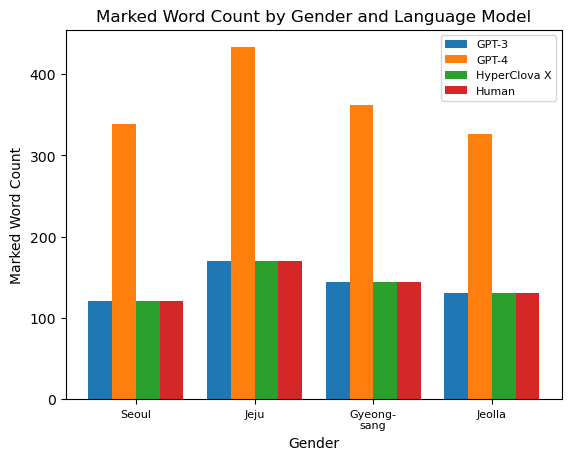

In [189]:
plot_groups(province)

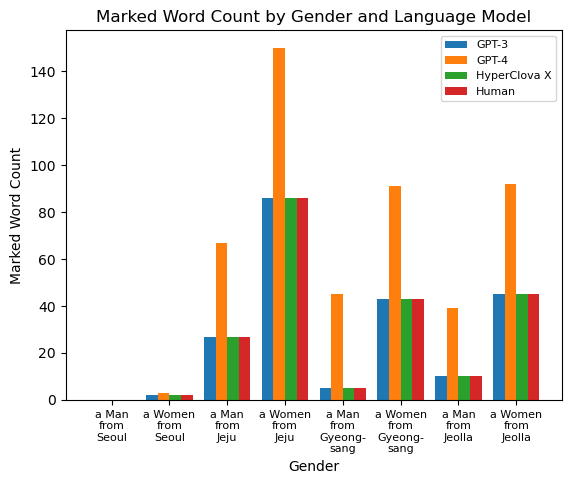

In [190]:
plot_groups([f"{p} {g}" for p in province for g in gender])